<a href="https://colab.research.google.com/github/remesis/BeatsAI/blob/main/LSTM_7050_BeatsAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import json
import os
import math
import librosa

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf

dataDir = "/content/drive/MyDrive/Data/genres_original"
jsonPath = "/content/data.json"
csvPath = "/content/drive/MyDrive/Data/features_30_sec.csv"


df = pd.read_csv(csvPath)

In [2]:
DATASET_PATH = dataDir
JSON_PATH = jsonPath
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [3]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        try:
            if dirpath is not dataset_path:
                semantic_label = dirpath.split("/")[-1]
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))
                for f in filenames:
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))
        except Exception as e:
            print(f"Error {e}")
            continue
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [4]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)



Processing: hiphop
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:1
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:2
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:3
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:4
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:5
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:6
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:7
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:8
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:9
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00005.wav, segment:10
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00011.wav, segment:1
/content/drive/MyDrive/Data/genres_original/hiphop/hiphop.00011.wav, segment:2
/content/drive/MyDrive/Data/gen

<ipython-input-3-6ccada1ba152>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00002.wav, segment:7
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00002.wav, segment:8
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00002.wav, segment:9
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00002.wav, segment:10
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:1
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:2
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:3
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:4
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:5
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:6
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:7
/content/drive/MyDrive/Data/genres_original/reggae/reggae.00003.wav, segment:8


In [5]:
with open(jsonPath, "r") as fp:
  data = json.load(fp)

X = np.array(data["mfcc"])
y = np.array(data["labels"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1] , X_train.shape[2])

In [6]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(64,input_shape = input_shape , return_sequences= True))
model.add(tf.keras.layers.LSTM(64))

model.add(tf.keras.layers.Dense(64 , activation = "relu"))
model.add(tf.keras.layers.Dense(10 , activation = "softmax"))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
236/236 [==============================] - 39s 144ms/step - loss: 2.1631 - accuracy: 0.2231 - val_loss: 1.9806 - val_accuracy: 0.3146
Epoch 2/100
236/236 [==============================] - 36s 152ms/step - loss: 1.7876 - accuracy: 0.3736 - val_loss: 1.6240 - val_accuracy: 0.4306
Epoch 3/100
236/236 [==============================] - 34s 145ms/step - loss: 1.5289 - accuracy: 0.4580 - val_loss: 1.4706 - val_accuracy: 0.4645
Epoch 4/100
236/236 [==============================] - 33s 138ms/step - loss: 1.3894 - accuracy: 0.5061 - val_loss: 1.3594 - val_accuracy: 0.5238
Epoch 5/100
236/236 [==============================] - 34s 145ms/step - loss: 1.3105 - accuracy: 0.5359 - val_loss: 1.3206 - val_accuracy: 0.5403
Epoch 6/100
236/236 [==============================] - 33s 141ms/step - loss: 1.2717 - accuracy: 0.5476 - val_loss: 1.2725 - val_accuracy: 0.5514
Epoch 7/100
236/236 [==============================] - 38s 163ms/step - loss: 1.2041 - accuracy: 0.5739 - val_loss: 1.2245 -

In [8]:
model.evaluate(X_test,y_test,verbose=0)


[1.132132887840271, 0.7049788236618042]

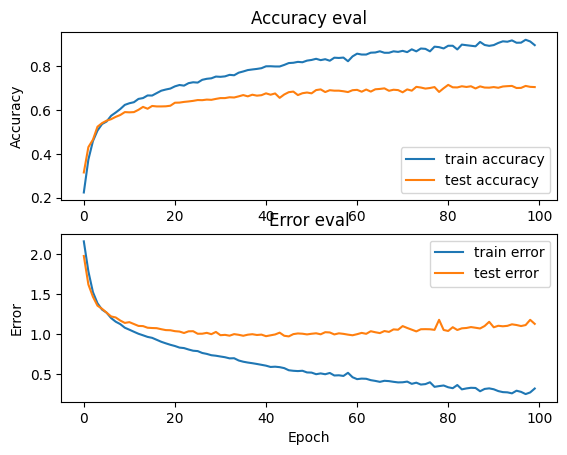

In [9]:
import matplotlib.pyplot as plt




fig, axs = plt.subplots(2)
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

#####ERROR#######################
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

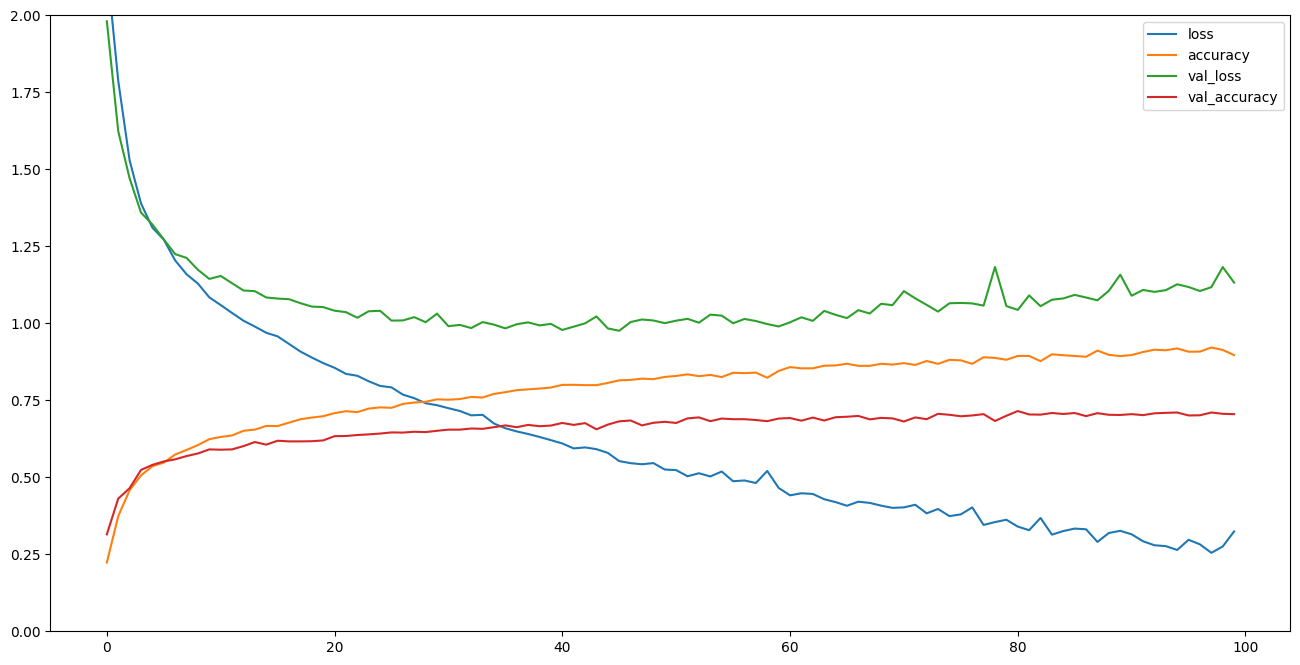

In [12]:
pd.DataFrame(history.history).plot(figsize=(16,8))
plt.ylim(0,2)
plt.show()

In [13]:
model_save_name = 'lstm_7050_BeatsAI.keras'
path = F"/content/drive/MyDrive/SavedModels/{model_save_name}"
history.model.save(path)